- 보스턴 집값예측
- linear

In [401]:
import pandas as pd
import torch
import torch.nn.functional as f
import torch.nn as nn
import torch.optim as optimize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from torchmetrics.regression import R2Score

In [402]:
torch.manual_seed(1)

In [403]:
bostonDF=pd.read_csv('../0910/boston.csv')
bostonDF.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [404]:
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [405]:
target=bostonDF[['MEDV']]
feature=bostonDF.drop(columns='MEDV')

print(f'feature : {feature.shape}, target : {target.shape}')

feature : (506, 13), target : (506, 1)


In [406]:
# 데이터셋 분리
X_train,X_test,y_train,y_test=train_test_split(feature,target,
                                               test_size=0.2,
                                               random_state=5)

X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,
                                             test_size=0.2,
                                             random_state=5)

print(f'X_train : {X_train.shape}, X_val : {X_val.shape}, X_test : {X_test.shape}')
print(f'y_train : {y_train.shape}, y_val : {y_val.shape}, y_test : {y_test.shape}')

X_train : (323, 13), X_val : (81, 13), X_test : (102, 13)
y_train : (323, 1), y_val : (81, 1), y_test : (102, 1)


In [407]:
# 스케일링 , 텐서
scale=StandardScaler()
scale.fit(X_train)
X_train=torch.FloatTensor(scale.transform(X_train))
X_val=torch.FloatTensor(scale.transform(X_val))
X_test=torch.FloatTensor(scale.transform(X_test))

y_train=torch.FloatTensor(y_train.values)
y_val=torch.FloatTensor(y_val.values)
y_test=torch.FloatTensor(y_test.values)

In [408]:
# 모델 인스턴스 호출
model=nn.Linear(13,1)
model=nn.Sequential(nn.Linear(13,20),
                    nn.ReLU(),
                    nn.Linear(20,20),
                    nn.ReLU(),
                    nn.Linear(20,20),
                    nn.ReLU(),
                    nn.Linear(20,10),
                    nn.ReLU(),
                    nn.Linear(10,1))
opti=optimize.Adam(model.parameters(),lr=0.01)

In [409]:
def testing(X,Y):
    with torch.no_grad():
        
        pred_y=model(X)
        test_loss=f.mse_loss(pred_y,Y).item()
        test_r2=R2Score()(pred_y,Y).item()

    return test_loss,test_r2

In [410]:
def training(X_train,y_train,X_val,y_val,X_test,y_test,EPOCH):
    loss_list=[[],[],[]]
    r2_list=[[],[],[]]
    for epoch in range(EPOCH):
        loss_sum=0
        r2_sum=0
        for i in range(BATCH_N):
            start=i*BATCH_SIZE
            end=start+BATCH_SIZE

            X_batch=X_train[start:end]
            y_batch=y_train[start:end]
            pred_y=model(X_batch)            

            batch_loss=f.mse_loss(pred_y,y_batch)

            opti.zero_grad()
            batch_loss.backward()
            opti.step()

            loss_sum+=batch_loss.item()
            r2_sum+= R2Score()(pred_y,y_batch).item()

        train_loss=loss_sum/BATCH_SIZE
        train_r2=r2_sum/BATCH_SIZE

        loss_list[0].append(train_loss)
        r2_list[0].append(train_r2)

        # val
        val_loss,val_r2=testing(X_val,y_val)
        loss_list[1].append(val_loss)
        r2_list[1].append(val_r2)

        # testing
        test_loss,test_r2=testing(X_test,y_test)
        loss_list[2].append(test_loss)
        r2_list[2].append(test_r2)


        print(f'[{epoch+1}/{EPOCH}] train_loss : {train_loss}, val_loss : {val_loss}, test_loss : {test_loss}')
        print(f'[{epoch+1}/{EPOCH}] train_r2 : {train_r2}, val_r2 : {val_r2}, test_r2 : {test_r2}')
    return loss_list,r2_list

In [411]:
epoch=100
BATCH_SIZE=30
BATCH_N=X_train.shape[0]//BATCH_SIZE
loss_list,r2_list=training(X_train,y_train,X_val,y_val,X_test,y_test,epoch)

[1/100] train_loss : 193.98162129720052, val_loss : 560.140625, test_loss : 524.2623901367188
[1/100] train_r2 : -2.09975152015686, val_r2 : -5.452307224273682, test_r2 : -5.696089744567871
[2/100] train_loss : 152.52726338704426, val_loss : 212.49703979492188, test_loss : 196.2830810546875
[2/100] train_r2 : -1.5767346541086833, val_r2 : -1.4477713108062744, test_r2 : -1.5070064067840576
[3/100] train_loss : 39.91044692993164, val_loss : 79.7535171508789, test_loss : 50.669307708740234
[3/100] train_r2 : -0.18865363597869872, val_r2 : 0.08131241798400879, test_r2 : 0.35283124446868896
[4/100] train_loss : 21.476480102539064, val_loss : 51.730751037597656, test_loss : 25.379459381103516
[4/100] train_r2 : 0.06714070041974386, val_r2 : 0.40410906076431274, test_r2 : 0.675843358039856
[5/100] train_loss : 11.017122968037922, val_loss : 37.44065856933594, test_loss : 18.918548583984375
[5/100] train_r2 : 0.19395652413368225, val_r2 : 0.5687178373336792, test_r2 : 0.7583646774291992
[6/100

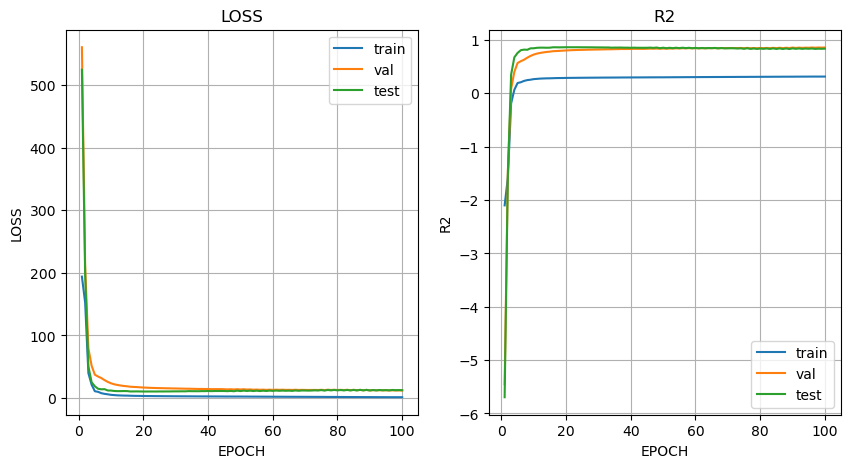

In [412]:
fig,ax=plt.subplots(1,2,figsize=(10,5))

ax[0].plot(range(1,epoch+1),loss_list[0],label='train')
ax[0].plot(range(1,epoch+1),loss_list[1],label='val')
ax[0].plot(range(1,epoch+1),loss_list[2],label='test')
ax[0].grid()
ax[0].set(xlabel='EPOCH',ylabel='LOSS',title='LOSS')
ax[0].legend()

ax[1].plot(range(1,epoch+1),r2_list[0],label='train')
ax[1].plot(range(1,epoch+1),r2_list[1],label='val')
ax[1].plot(range(1,epoch+1),r2_list[2],label='test')
ax[1].grid()
ax[1].set(xlabel='EPOCH',ylabel='R2',title='R2')
ax[1].legend()

plt.show()